In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from scene_synthesis.datasets.nuScenes import NuScenesDataset
from scene_synthesis.datasets.utils import collate_train
from scene_synthesis.networks.feature_extractors import ResNet18
from scene_synthesis.networks.autoregressive_transformer import AutoregressiveTransformer

def to_numpy(data: dict):
    for k in data:
        if isinstance(data[k], torch.Tensor):
            data[k] = data[k].squeeze()
            if not data[k].shape:
                data[k] = data[k].item()
            else:
                data[k] = data[k].numpy()
        elif isinstance(data[k], dict):
            to_numpy(data[k])


In [2]:
plt.ion()
# np.random.seed(0)
# torch.manual_seed(0)
dataset = NuScenesDataset("/media/yifanlin/My Passport/data/nuScene-processed", train=True)
axes_limit = 40
cat2color = {1: 'red', 2: 'blue', 3: 'green'}
feature_extractor = ResNet18(4, 512)
model = AutoregressiveTransformer(feature_extractor)
model.load_state_dict(torch.load('./ckpts/shareMixture'))


<All keys matched successfully>

In [19]:
data = dataset[0]
input_data, length, _ = collate_train([data])
for k in data:
    data[k] = input_data[k].squeeze(0).numpy()


In [34]:
condition = {
    "category": 3,  # int
    "location": None,  # (1, 2)
    "bbox": None,  # (1, 2), (1, 1)
    "velocity": None  # (1, 1), (1, 1), (1, 1)
}

array([[ 0.84399998,  2.22900009,  4.05945778],
       [ 0.93400002,  0.89099997,  6.21312428],
       [ 2.81386638, 12.94290257,  1.06571031],
       [ 2.82977319, 16.04081917, -0.86434078],
       [ 0.69      ,  0.76099998,  3.15326548],
       [ 2.42489004,  4.80124283,  1.51969838]])

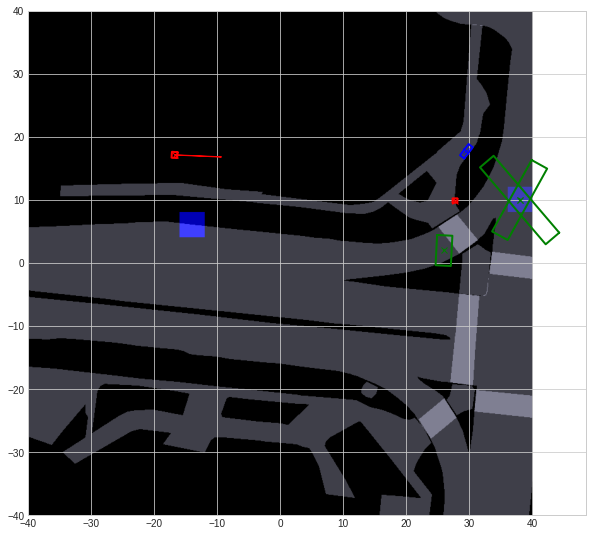

In [30]:
preds, probs = model.generate(input_data, length, condition)
to_numpy(preds)
category = preds['category']
if category != 0:
    preds['location'] = np.array([preds['location'] // 20, preds['location'] % 20]) * 4 - 40 + 2
    data['category'] = np.concatenate([data['category'], np.array([preds['category']])], axis=0)
    data['location'] = np.concatenate([data['location'], preds['location'].reshape(1, -1)], axis=0)
    data['bbox'] = np.concatenate([data['bbox'], np.concatenate([preds['bbox']['wl'], np.array([preds['bbox']['theta']])], axis=0).reshape(1, -1)], axis=0)
    data['velocity'] = np.concatenate([data['velocity'], np.array([[preds['velocity']['s'] * preds['velocity']['moving'], preds['velocity']['omega']]])], axis=0)
    idx = list(range(len(data['category'])))
    idx.sort(key=lambda x: (-data['location'][x][1], data['location'][x][0]))
    for k in ['category', 'location', 'bbox', 'velocity']:
        data[k] = data[k][idx]
    input_data['category'] = torch.tensor(data['category'])
    for k in ['location', 'bbox', 'velocity', 'map']:
        input_data[k] = torch.tensor(data[k], dtype=torch.float)
    input_data, length, _ = collate_train([input_data], keep_all=True)

_, ax = plt.subplots(figsize=(10, 10))
map_layers = data['map'].sum(axis=0)
map_layers /= map_layers.max() * 2
map_layers = np.stack([map_layers] * 3, axis=-1)
grid = np.meshgrid(np.arange(-axes_limit, axes_limit, 4), np.flip(np.arange(-axes_limit, axes_limit, 4)))
grid = np.stack(grid, axis=-1)
grid = (grid + 40) // 4
grid = grid[..., 0] * 20 + grid[..., 1]
prob_map = np.exp(probs['location'].log_prob(torch.tensor(grid)).numpy())
prob_map = np.kron(prob_map, np.ones((40, 40)))
map_layers[..., 2] += prob_map
map_layers[..., 2] /= map_layers[..., 2].max()
ax.imshow(map_layers, extent=[-axes_limit, axes_limit, -axes_limit, axes_limit])
for i in range(length.item()):
    if data['category'][i] != 0:
        color = cat2color[data['category'][i]]
        loc = data['location'][i]
        ax.plot(loc[0], loc[1], 'x', color=color)
        w, l, theta = data['bbox'][i]
        corners = np.array([[l / 2, w / 2],
                            [-l / 2, w / 2],
                            [-l / 2, -w / 2],
                            [l / 2, -w / 2],
                            [l / 2, w / 2]])
        rotation = np.array([[np.cos(theta), np.sin(theta)],
                             [-np.sin(theta), np.cos(theta)]])
        corners = np.dot(corners, rotation) + loc
        ax.plot(corners[:, 0], corners[:, 1], color=color, linewidth=2)
        speed, omega = data['velocity'][i]
        rotation = np.array([[np.cos(omega), np.sin(omega)],
                             [-np.sin(omega), np.cos(omega)]])
        velocity = np.dot(np.array([speed, 0]), rotation)
        ax.arrow(loc[0], loc[1], velocity[0] * 5, velocity[1] * 5, color=color, width=0.05)


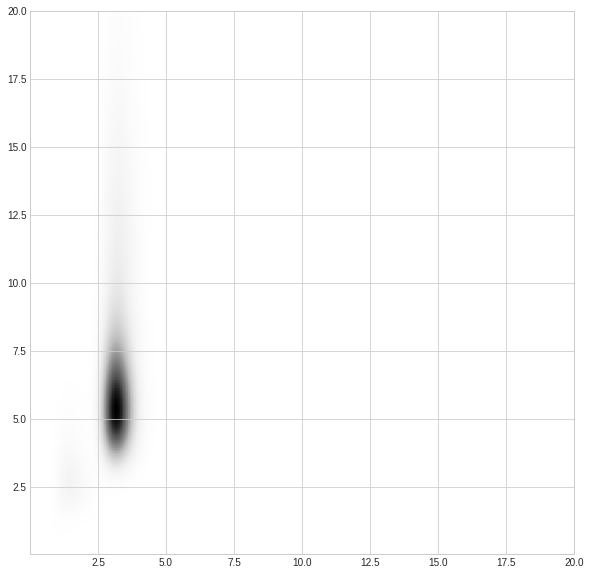

In [28]:
grid = np.meshgrid(np.linspace(0.01, 20, 200), np.linspace(20, 0.01, 200))
grid = np.stack(grid, axis=-1)
prob_map = np.exp(probs['bbox']['wl'].log_prob(torch.tensor(grid)).numpy())
plt.figure(figsize=(10, 10))
plt.imshow(prob_map, extent=[0.01, 20, 0.01, 20])

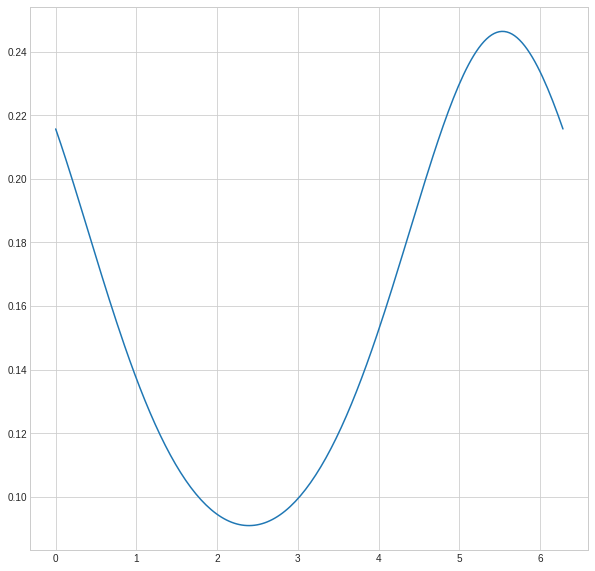

In [31]:
grid = np.linspace(0, 2 * np.pi, 200)[..., None]
prob_map = np.exp(probs['bbox']['theta'].log_prob(torch.tensor(grid)).numpy())
plt.figure(figsize=(10, 10))
plt.plot(grid, prob_map)

In [32]:
probs['bbox']['theta'].mixture_distribution.logits

tensor([[-3.8120, -8.2356, -7.9626, -8.1378, -8.0358, -1.3790, -8.3615, -2.8922,
         -8.1661, -0.4022]])

In [33]:
probs['bbox']['theta'].component_distribution.variance

tensor([[[0.7584],
         [0.7686],
         [0.7695],
         [0.7695],
         [0.7686],
         [0.7578],
         [0.7689],
         [0.7582],
         [0.7679],
         [0.7577]]])

In [45]:
import torch
from torch.distributions import VonMises
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
import numpy as np

class Test(nn.Module):
    def __init__(self):
        super().__init__()
        self.loc = nn.Parameter(torch.randn(1))
        self.concentration = nn.Parameter(torch.randn(1))
    def forward(self):
        prob = VonMises(self.loc, torch.exp(self.concentration) * 0.5)
        return -prob.log_prob(torch.tensor([1.57]))

test = Test()
optimizer = Adam(test.parameters(), lr=1e-3)

In [52]:
for i in range(200):
    optimizer.zero_grad()
    loss = test()
    print(f'{i}: {loss.item()}')
    loss.backward()
    optimizer.step()

0: 1.1971526145935059
1: 1.196131706237793
2: 1.1951106786727905
3: 1.194089412689209
4: 1.193068265914917
5: 1.1920467615127563
6: 1.1910252571105957
7: 1.1900036334991455
8: 1.1889820098876953
9: 1.1879602670669556
10: 1.1869382858276367
11: 1.1859163045883179
12: 1.184894323348999
13: 1.1838719844818115
14: 1.1828497648239136
15: 1.1818275451660156
16: 1.1808052062988281
17: 1.1797826290130615
18: 1.178760051727295
19: 1.1777373552322388
20: 1.176714539527893
21: 1.1756917238235474
22: 1.174668788909912
23: 1.1736459732055664
24: 1.1726229190826416
25: 1.1715997457504272
26: 1.1705766916275024
27: 1.1695533990859985
28: 1.1685302257537842
29: 1.1675068140029907
30: 1.1664835214614868
31: 1.1654599905014038
32: 1.1644365787506104
33: 1.1634129285812378
34: 1.1623892784118652
35: 1.1613657474517822
36: 1.1603420972824097
37: 1.1593183279037476
38: 1.1582945585250854
39: 1.1572707891464233
40: 1.1562469005584717
41: 1.15522301197052
42: 1.1541991233825684
43: 1.1531751155853271
44: 1.1

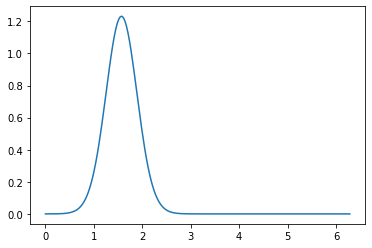

In [53]:
prob = VonMises(test.loc, torch.exp(test.concentration) * 0.5)
grid = np.linspace(0, 2 * np.pi, 200)[..., None]
prob_map = np.exp(prob.log_prob(torch.tensor(grid)).detach().numpy())
plt.plot(grid, prob_map)
plt.show()

In [54]:
test.concentration

Parameter containing:
tensor([2.9753], requires_grad=True)

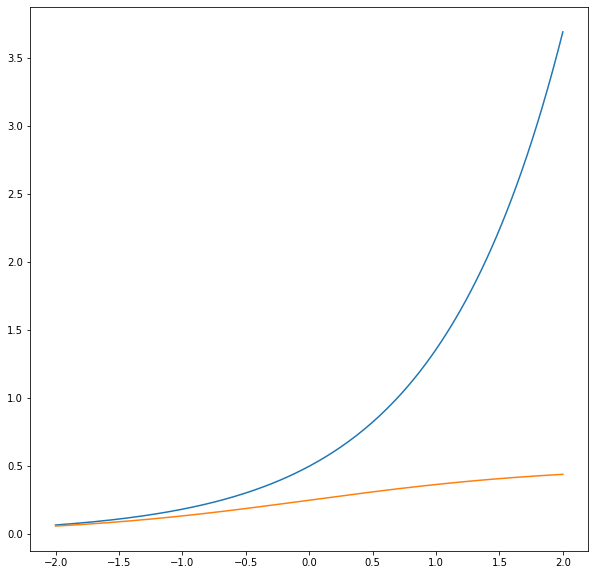

In [44]:
x = torch.linspace(-2, 2, 200)
y1 = torch.exp(x) * 0.5
y2 = torch.sigmoid(x) * 0.5
plt.figure(figsize=(10, 10))
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()